In [ ]:
!pip install tensorflow tensorflow-gpu

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\ahmed\AppData\Local\Temp\pip-install-y4z10c8o\tensorflow-gpu_9833235febac48e7a4b4e5f115114b6f\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-exited-with-error
  
  Running setup.py install for tensorflow-gpu did not

In [ ]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
print(tf.config.list_physical_devices('GPU'))

NameError: ignored

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')
# # Make the directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [ ]:
!tar -xf lfw.tar

tar: Error opening archive: Failed to open 'lfw.tar'


In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        OLD_PATH=os.path.join('lfw',directory,file)
        NEW_PATH=os.path.join(NEG_PATH,file)
        os.replace(OLD_PATH,NEW_PATH)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [ ]:
import uuid

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame=frame[120:120+250,200:200+250,:]
    cv2.imshow("MyImage",frame)
    if cv2.waitKey(1) & 0XFF == ord('a'):
        IMG_NAME=os.path.join(ANC_PATH,"{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(IMG_NAME,frame)
    if cv2.waitKey(1) & 0XFF == ord('p'):
        IMG_NAME=os.path.join(POS_PATH,"{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(IMG_NAME,frame)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [4]:
anchor=tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(400)
positive=tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(400)
negative=tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(400)

In [5]:
def preprocess (file_path):
    fimg=tf.io.read_file(file_path)
    img=tf.io.decode_jpeg(fimg)
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [6]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data=positives.concatenate(negatives)

(b'data/anchor/ad663e4f-351c-11ee-813d-b40edeb3ee89.jpg',
 b'data/positive/63d0e62e-351d-11ee-a3f4-b40edeb3ee89.jpg',
 1.0)

In [7]:
def preprocess_all(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label)

In [8]:
data=data.map(preprocess_all)
data=data.cache()
data=data.shuffle(buffer_size=1024)

In [ ]:
sample=data.as_numpy_iterator()

In [ ]:
ex=sample.next()[2]
ex

0.0

In [9]:
train_data=data.take(round(len(data)*0.7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)

In [ ]:
train_data.as_numpy_iterator().next()[2]

array([0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
      dtype=float32)

In [10]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [11]:
def make_embeddding():
    inp=Input(shape=(100,100,3),name="Input")
    c1=Conv2D(64,(10,10),activation="relu")(inp)
    m1=MaxPooling2D(64,(2,2),padding="same")(c1)
    c2=Conv2D(128,(7,7),activation="relu")(m1)
    m2=MaxPooling2D(64,(2,2),padding="same")(c2)
    c3=Conv2D(128,(4,4),activation="relu")(m2)
    m3=MaxPooling2D(64,(2,2),padding="same")(c3)
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    return Model(inputs=[inp],outputs=[d1],name="embedding")

In [12]:
embedding=make_embeddding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [13]:
class L1Distance(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    def call(self,input_image,validation_image):
        return tf.math.abs(input_image-validation_image)


In [14]:
def make_siamese():
    input_image=Input(shape=(100,100,3),name="Input Image")
    validation_image=Input(shape=(100,100,3),name=" validation Image")

    l1dist=L1Distance()
    siamese_distance=l1dist(embedding(input_image),embedding(validation_image))
    classification=Dense(1,activation="sigmoid",name="classification")(siamese_distance)

    return Model(inputs=[input_image,validation_image],outputs=classification,name="siamese_Model")

In [15]:
siames=make_siamese()
siames.summary()

Model: "siamese_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input Image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
  validation Image (InputLayer)  [(None, 100, 100, 3  0          []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['Input Image[0][0]',            
                                                                  ' validation Image[0

In [16]:
opt=tf.keras.optimizers.Adam(1e-4)
loss=tf.keras.losses.BinaryCrossentropy()


In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siames=siames)

In [18]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X=batch[:2]
        y=batch[2]
        yhat = siames(X, training=True)
        # Calculate loss
        b_loss = loss(y, yhat)
    grad = tape.gradient(b_loss, siames.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siames.trainable_variables))

    # Return loss
    return b_loss

In [19]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [20]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
35/35 [==============================] - 20s 189ms/step

 Epoch 2/50
35/35 [==============================] - 6s 167ms/step

 Epoch 3/50
35/35 [==============================] - 6s 165ms/step

 Epoch 4/50
35/35 [==============================] - 6s 164ms/step

 Epoch 5/50
35/35 [==============================] - 6s 161ms/step

 Epoch 6/50
35/35 [==============================] - 6s 161ms/step

 Epoch 7/50
35/35 [==============================] - 6s 163ms/step

 Epoch 8/50
35/35 [==============================] - 6s 163ms/step

 Epoch 9/50
35/35 [==============================] - 6s 165ms/step

 Epoch 10/50
35/35 [==============================] - 6s 167ms/step

 Epoch 11/50
35/35 [==============================] - 6s 168ms/step

 Epoch 12/50
35/35 [==============================] - 6s 170ms/step

 Epoch 13/50
35/35 [==============================] - 6s 169ms/step

 Epoch 14/50
35/35 [==============================] - 6s 167ms/step

 Epoch 15/50
35/35 [=====================

In [21]:

# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [22]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()


In [ ]:
samp.next()[2]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [23]:
yhat=siames.predict([test_input,test_val])
yhat

1/1 [==============================] - 0s 156ms/step


array([[5.0779891e-09],
       [1.1909138e-07],
       [1.0000000e+00],
       [2.4423814e-05],
       [2.0545172e-06],
       [3.4549474e-05],
       [1.0000000e+00],
       [1.0000000e+00],
       [3.2454412e-04],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.0603489e-05],
       [5.3783395e-05],
       [5.7683716e-04],
       [6.8952278e-07],
       [6.1363522e-07]], dtype=float32)

In [24]:
[1 if prediction >0.5 else 0 for prediction in yhat]


[0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0]

In [25]:
m = Recall()

# Calculating the recall value
m.update_state(y_true, yhat)

# Return Recall Result
m.result().numpy()

1.0

In [26]:
m = Precision()

# Calculating the recall value
m.update_state(y_true, yhat)

# Return Recall Result
m.result().numpy()

1.0

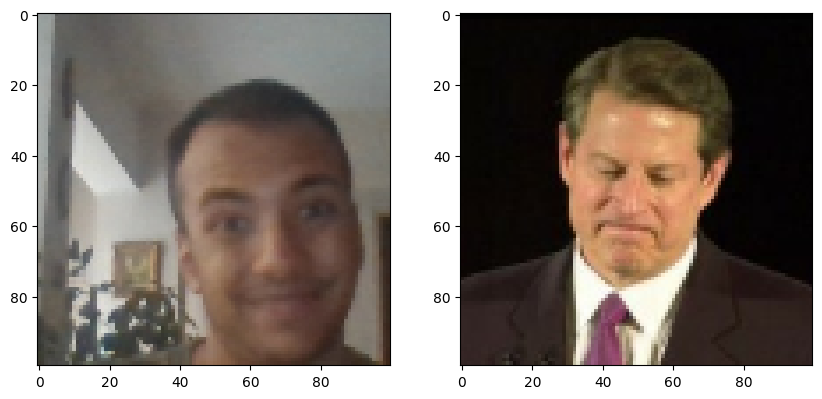

In [27]:
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [28]:
siames.save('siamesemodelv2.h5')

In [30]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5',
                                   custom_objects={'L1Distance':L1Distance, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})